#  Прогнозирование заказов такси

Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Постройте модель для такого предсказания.

Значение метрики *RMSE* на тестовой выборке должно быть не больше 48.

Порядок выполнения:

1. Загрузить данные и выполнить их ресемплирование по одному часу.
2. Проанализировать данные.
3. Обучить разные модели с различными гиперпараметрами. Сделать тестовую выборку размером 10% от исходных данных.
4. Проверить данные на тестовой выборке и сделать выводы.


Количество заказов находится в столбце `num_orders`.

In [2]:
import sklearn
sklearn.__version__

'1.1.3'

In [3]:
!pip install phik -q

In [5]:
RAND=10

In [4]:
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import phik
import seaborn as sb
import sklearn
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split,RandomizedSearchCV,GridSearchCV,TimeSeriesSplit
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import OneHotEncoder,OrdinalEncoder,RobustScaler,StandardScaler,MinMaxScaler
from sklearn.tree import DecisionTreeRegressor

from statsmodels.tsa.seasonal import seasonal_decompose as sd

In [7]:
plt.rcParams['figure.figsize'] = [25, 8]

## Подготовка

In [8]:
path="C:\\Progs\\Anaconda3\\envs\\practicum\\df\\taxi.csv"
if os.path.exists(path):
    df=pd.read_csv(path,parse_dates=[0])
else:
    print('Файл не существует')

In [9]:
df.head()

,datetime,num_orders
0,2018-03-01 00:00:00,9
1,2018-03-01 00:10:00,14
2,2018-03-01 00:20:00,28
3,2018-03-01 00:30:00,20
4,2018-03-01 00:40:00,32


In [10]:
df['datetime'].duplicated().sum()

0

Дубликатов во времени нет.

In [11]:
df=df.set_index('datetime').sort_index().resample('1H').sum()

In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4416 entries, 2018-03-01 00:00:00 to 2018-08-31 23:00:00
Freq: H
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  4416 non-null   int64
dtypes: int64(1)
memory usage: 69.0 KB


Пропусков нет.

In [13]:
(30*6+4)*24

4416

Присутствуют данные за каждый час периода.

## Анализ

In [14]:
decomp=sd(df)

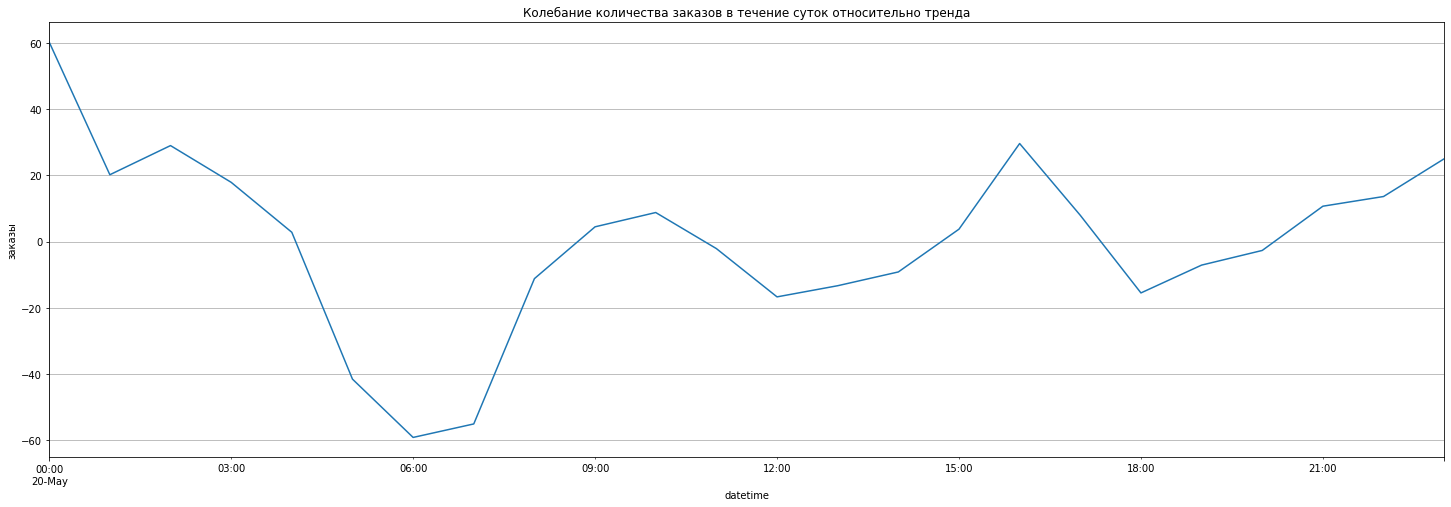

In [15]:
decomp.seasonal['2018-05-20'].plot(figsize=(25,8),grid=True,ylabel='заказы',
                   title='Колебание количества заказов в течение суток относительно тренда');

Суточная амплитуда колебания 120, макимально - в полночь, минимально - в 6 утра. В первой половине дня пик в 10 ч, во второй - в 16 ч.

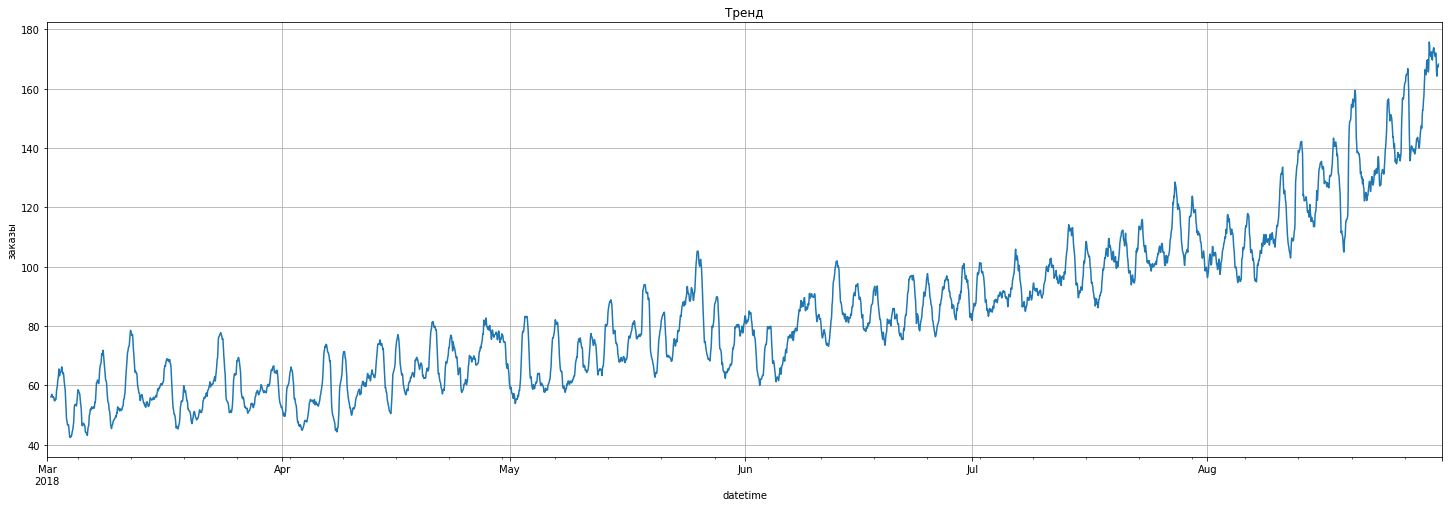

In [16]:
decomp.trend.plot(figsize=(25,8),grid=True,ylabel='заказы',title='Тренд');

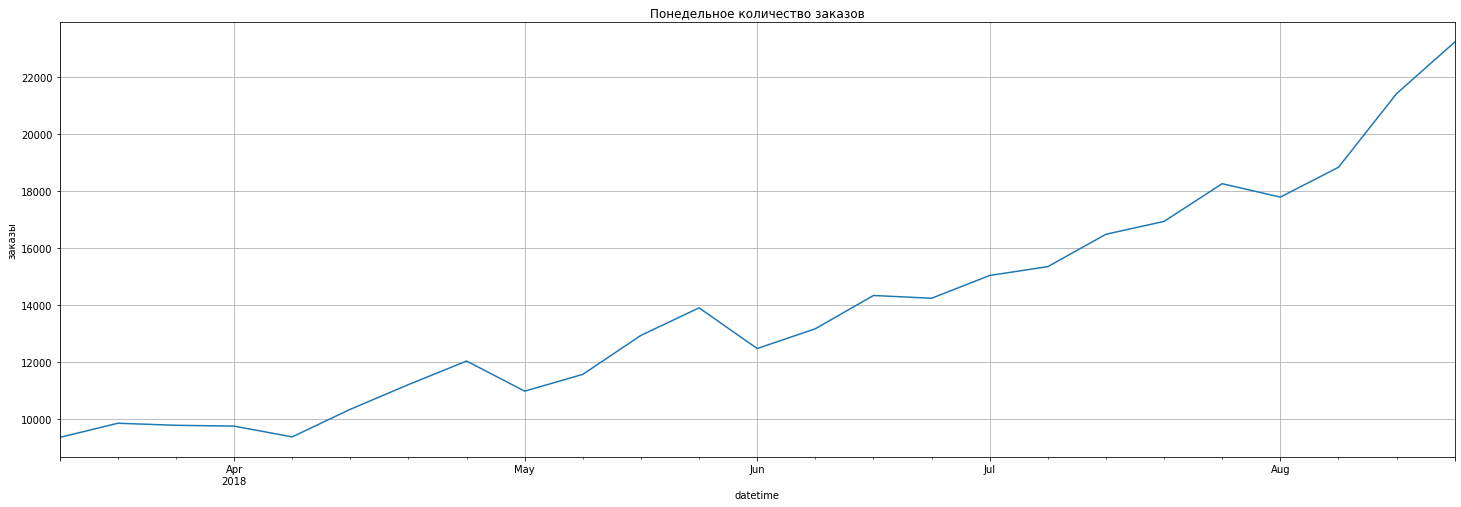

In [17]:
decomp.trend.resample('1W').sum().iloc[1:-1].plot(figsize=(25,8),grid=True,ylabel='заказы',
                                       title='Понедельное количество заказов');

Количество заказов росло в рассматриваемый период. В апреле, мае, июле пики под конец месяца.

In [18]:
df['dow']=df.index.dayofweek
df['day']=df.index.day
df['month']=df.index.month

В связи с помесячной цикличностью введу также разделение месяца на четверти.

In [19]:
df['month_record']=(df['day']-1)*24+df.index.hour

In [20]:
def quarta(row):
    count=df.loc[df['month']==row['month'],'day'].max()*24/4
    number=row['month_record']
    for i in range(1,5):
        if number<i*count:
            return i

In [21]:
df['qom']=df.apply(quarta,1)

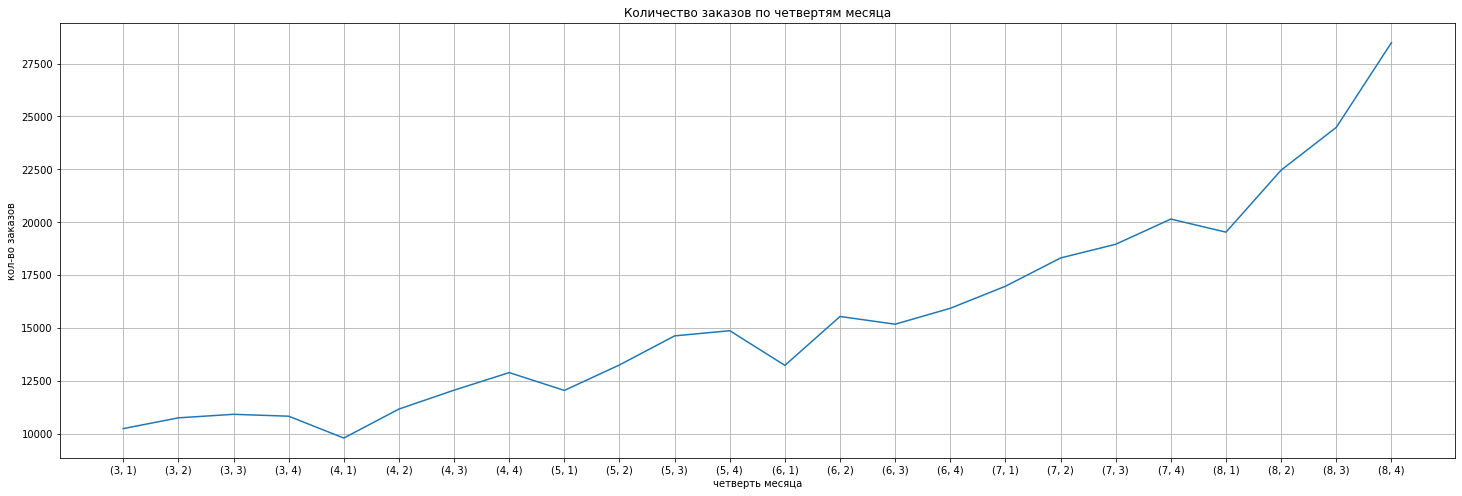

In [22]:
df.groupby(['month','qom'])['num_orders'].sum().plot(grid=True,figsize=(25,8),xticks=range(24),
                    xlabel='четверть месяца',ylabel="кол-во заказов",
                    title='Количество заказов по четвертям месяца');

Каждую первую четверть месяца, кроме июля, количество заказов проседает.

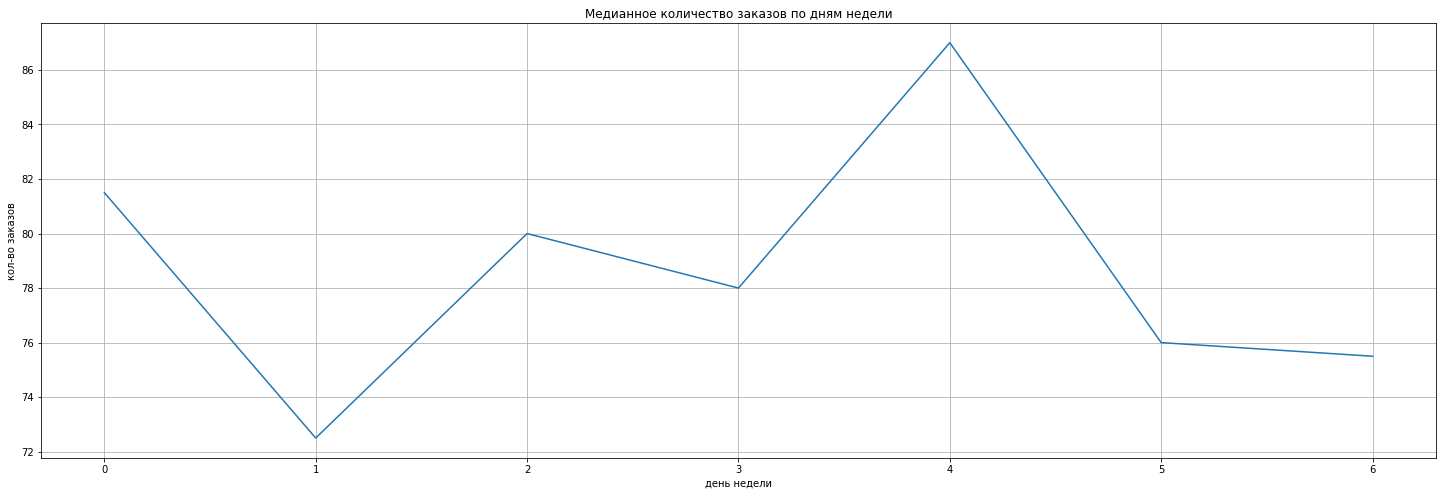

In [23]:
df.groupby(['dow'])['num_orders'].median().plot(grid=True,figsize=(25,8),
            xlabel='день недели',ylabel="кол-во заказов",
                    title='Медианное количество заказов по дням недели');

Максимальное количество заказов в пятницу, минимальное - во вторник.

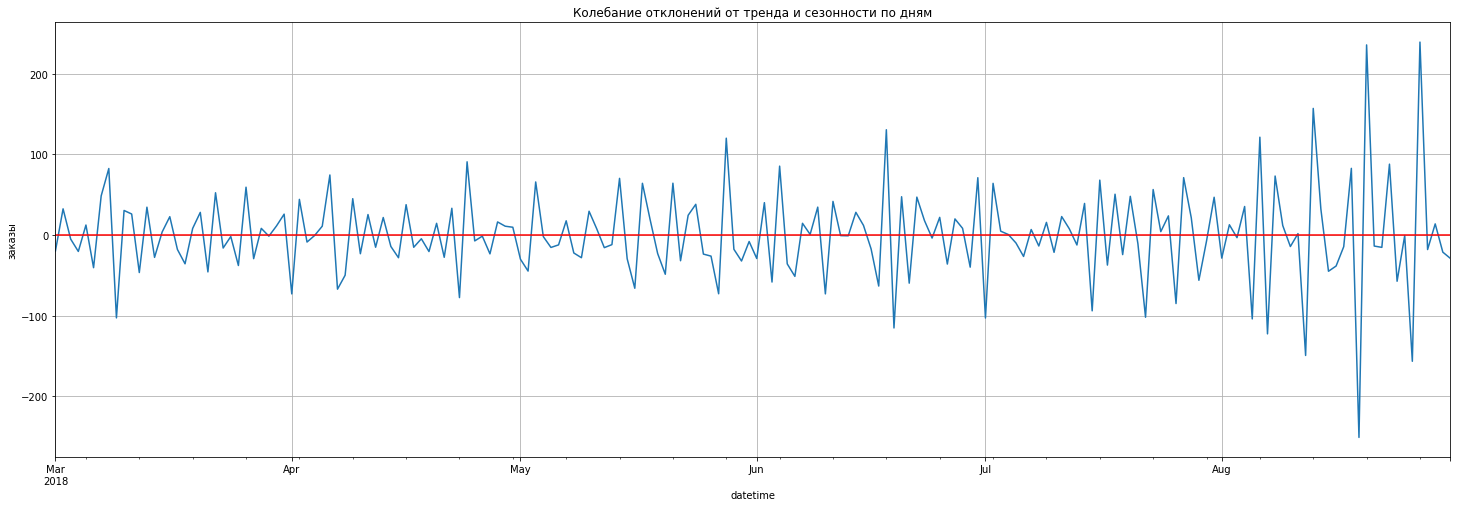

In [24]:
decomp.resid.resample('1D').sum().plot(figsize=(25,8),grid=True,ylabel='заказы',
                title='Колебание отклонений от тренда и сезонности по дням')
plt.axhline(color='red',y=0);

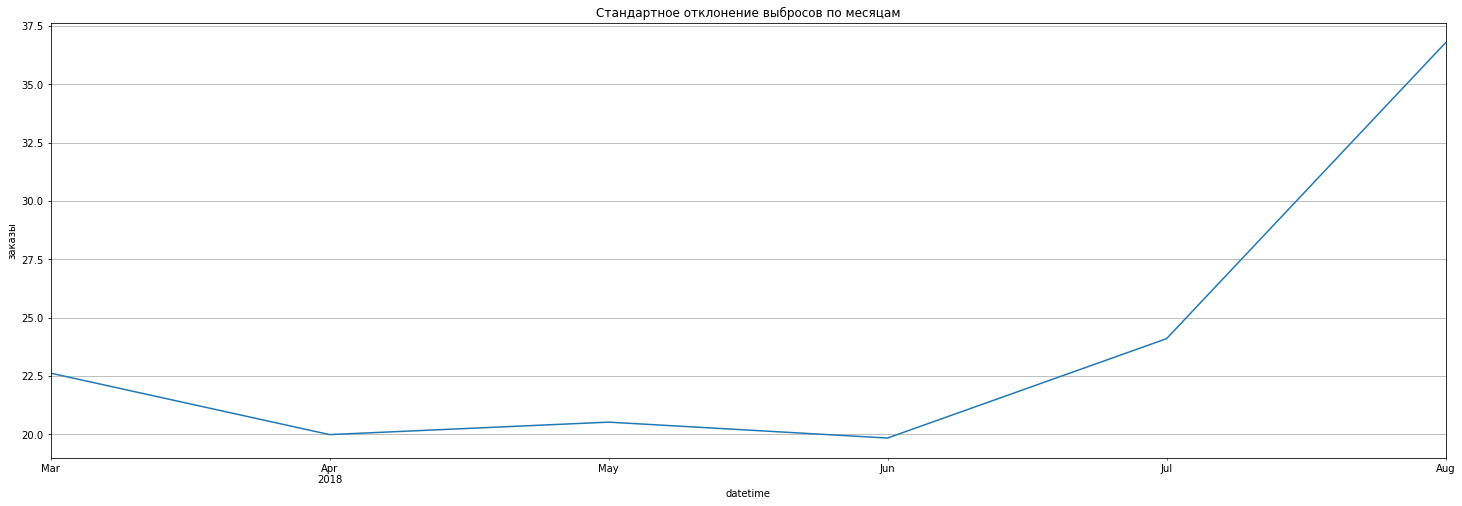

In [25]:
decomp.resid.resample('1M').std().plot(figsize=(25,8),grid=True,
                ylabel='заказы', title='Стандартное отклонение выбросов по месяцам');

Остатки с нарастающей с июня амплитудой колеблятся вокруг ноля.

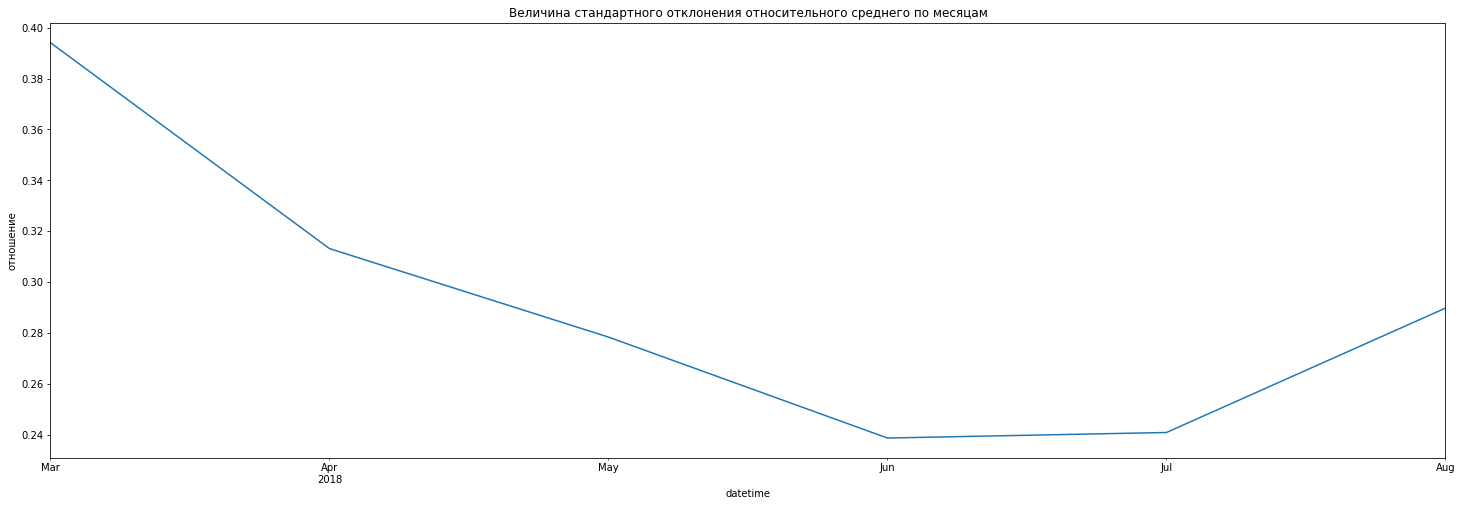

In [26]:
(decomp.resid.resample('1M').std()/decomp.trend.resample('1M').mean()).plot(figsize=(25,8),
                   title='Величина стандартного отклонения относительного среднего по месяцам',
                                                            ylabel='отношение');

Чем больше величины, тем больше в абсолютных значениях их отклонение. Но относительного величины количества заказов больше выбросов было в марте.\
Остатки распределены нормально.

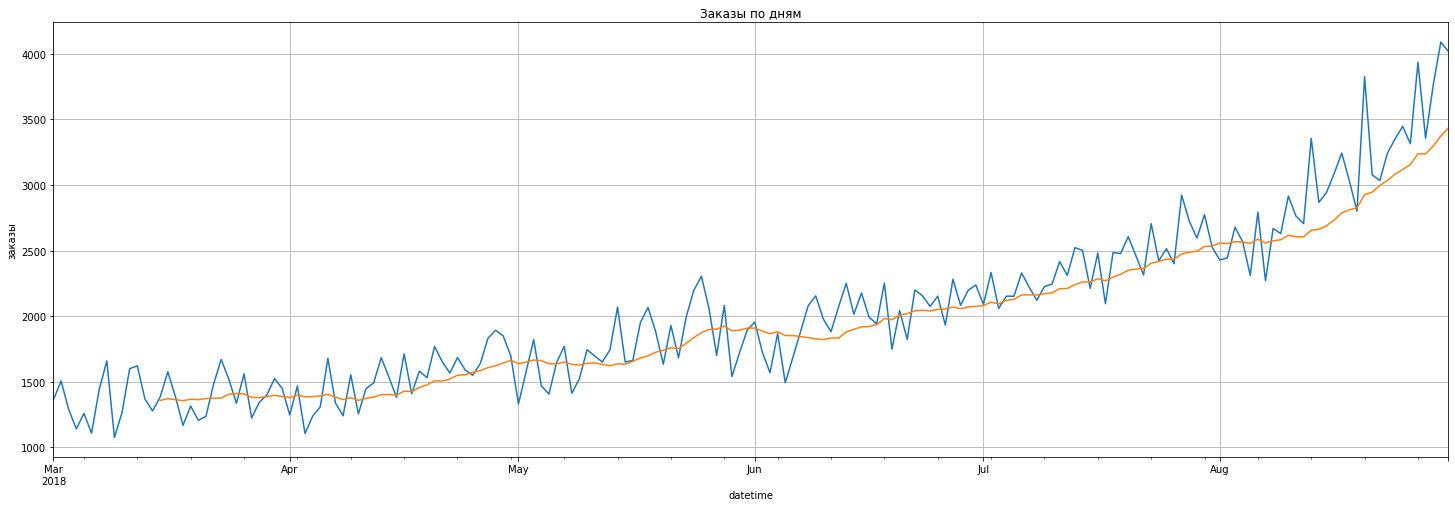

In [27]:
ax=df['num_orders'].resample('1D').sum().plot(figsize=(25,8),
                   title='Заказы по дням', ylabel='заказы')
df['num_orders'].resample('1D').sum().rolling(15).mean().plot(grid=True);

Количество заказов растёт. С марта по август среднее за 15 дней увеличилось в 2.5 раза.

Ряд ежедневного количества заказов не стационарен: среднее ряда по 15 дням имеет тенденцию роста, увеличивающегося в конце периода.

### Вывод

- Данные с 2018-03-01 00 ч по 2018-08-31 23ч.
- Пропусков нет.
- Суточная амплитуда колебания 120, макимально - в полночь, минимально - в 6 утра. В первой половине дня пик в 10 ч, во второй - в 16 ч.
- Количество заказов росло в рассматриваемый период. 
- Каждую первую четверть месяца, кроме июля, количество заказов проседает.
- Максимальное количество заказов в пятницу, минимальное - во вторник.
- Шум имеет нормальное распределение.
- Ряд ежедневного количества заказов не стационарен: среднее ряда по 15 дням имеет тенденцию роста, увеличивающегося в конце периода.

## Обучение

In [28]:
df.columns

Index(['num_orders', 'dow', 'day', 'month', 'month_record', 'qom'], dtype='object')

Я уже создала признаки четверти месяца, дня недели и дня. Стоит добавить признак часа, и не понадобится промежуточный признак порядкового номера записи в месяце.
    Также удалю из признаков месяц.

In [29]:
df['hour']=df.index.hour

In [30]:
df=df.drop(['month_record','month'],axis=1)

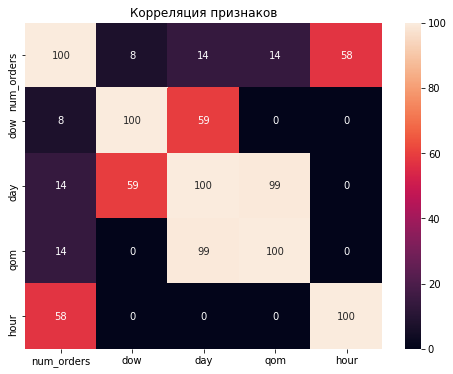

In [31]:
plt.figure(figsize=(8,6))
sb.heatmap((df.phik_matrix(interval_cols=['num_orders']))*100,
           annot=True,fmt='.0f')
plt.title('Корреляция признаков');

Мультиколлинеарность дня и четверти месяца - оставлю четверть месяца.

In [32]:
df=df.drop('day',1)

In [33]:
rang=['dow','qom','hour']

In [34]:
categories=[]
for cat in rang:
    categories.append(df.groupby(cat)['num_orders'].median().sort_values().index.tolist())

Упорядочила значения ранговых признаков по их вкладу в целевую переменную.

In [35]:
categories

[[1, 6, 5, 3, 2, 0, 4],
 [1, 2, 3, 4],
 [6,
  7,
  5,
  12,
  18,
  13,
  8,
  14,
  19,
  11,
  20,
  15,
  9,
  4,
  17,
  10,
  22,
  21,
  1,
  3,
  2,
  23,
  16,
  0]]

Для месяца и четверти вклад пропорционален величине значения, для дня недели и часа - не пропорционален, в их числовом типе нет смысла, а OrdinalEncoder требует отсортированность числовых значений по их величине, переведу час и день в строку.

In [36]:
nom=['dow','hour']
for col in nom:
    df[col]=df[col].astype(str)
dow=list(map(str,categories[0]))
hour=list(map(str,categories[2]))
rang=['qom']
cats_rang=[categories[1]]
cats_nom=[dow,hour]

In [37]:
cats_nom

[['1', '6', '5', '3', '2', '0', '4'],
 ['6',
  '7',
  '5',
  '12',
  '18',
  '13',
  '8',
  '14',
  '19',
  '11',
  '20',
  '15',
  '9',
  '4',
  '17',
  '10',
  '22',
  '21',
  '1',
  '3',
  '2',
  '23',
  '16',
  '0']]

У меня в цикле копия эта делалась, потому что я перебирала параметры для создания признаков. Сейчас я остановилась на 24ч и убираю функцию.

In [38]:
table=pd.DataFrame(columns=['mean_test_score','mean_fit_time','mean_score_time','params'])

In [39]:
def pipe_():
    col_prepair = ColumnTransformer(
            [('rang',
  OrdinalEncoder(categories=cats_rang,handle_unknown='use_encoded_value',unknown_value=4),
              rang),
              ('nom',
      make_pipeline(
  OrdinalEncoder(categories=cats_nom,handle_unknown='use_encoded_value',unknown_value=np.nan),
     SimpleImputer(missing_values=np.nan,strategy='most_frequent')             
                  ),
              nom),  
             ('num', RobustScaler(),num)],
            remainder='passthrough')
    return Pipeline([('col_prepair',col_prepair),
                         ('models', LinearRegression())])

In [40]:
params_=[{'models': [DecisionTreeRegressor(random_state=RAND)],
       'models__max_depth': [None] + [i for i in range(2, 7)],
        'models__min_samples_leaf': range(1, 10),
        'models__min_samples_split': range(2, 10),
        'models__max_leaf_nodes':range(10,300),
         'col_prepair__num': [RobustScaler(),StandardScaler(), MinMaxScaler(),'passthrough']
         },
        {'models':[GradientBoostingRegressor(random_state=RAND)],
        'models__max_depth': [None] + [i for i in range(2, 7)],
        'models__min_samples_leaf': range(1, 10),
        'models__min_samples_split': range(2, 10),
        'models__max_leaf_nodes':range(10,300),
         'col_prepair__num': [RobustScaler(),StandardScaler(), MinMaxScaler(),'passthrough']
        },
          {'models':[LinearRegression()],
            'col_prepair__num': [RobustScaler(),StandardScaler(), MinMaxScaler(),'passthrough'],
           'col_prepair__nom':[OneHotEncoder(drop='first',handle_unknown='ignore')]
          }]

Данные имеют суточную цикличность - оптимально добавить в обучение именно данные за последние сутки.

In [41]:
%%time
max_lag=24
rolling_mean_size=24
data=df.copy()
num=['rolling_mean']#количественные признаки
for lag in range(1, max_lag + 1):
    data['lag_'+str(lag)] = data['num_orders'].shift(lag)
    num.append('lag_'+str(lag))
data['rolling_mean']=data['num_orders'].shift(1).rolling(rolling_mean_size).mean()
train, test = train_test_split(data, shuffle=False, test_size=0.1)
train = train.dropna()
X_train=train.drop('num_orders',axis=1)
y_train=train['num_orders']
X_test=test.drop('num_orders',axis=1)
y_test=test['num_orders']

for i in range(3):
    params=params_[i]
    
    pipe=pipe_()
    
    split=TimeSeriesSplit()
    search=RandomizedSearchCV(pipe,params, scoring='neg_root_mean_squared_error',
                               n_jobs=-1,random_state=RAND,n_iter=10,error_score='raise',cv=split)
    
    search.fit(X_train,y_train)
    
    best=pd.DataFrame(search.cv_results_)\
    [['mean_fit_time','mean_score_time','params','mean_test_score']]\
    .sort_values('mean_test_score',ascending=False).iloc[:3]
    best['mean_test_score']=-best['mean_test_score']
    table=pd.concat([table,best])
table

/opt/conda/lib/python3.9/site-packages/sklearn/model_selection/_search.py:306: UserWarning: The total space of parameters 4 is smaller than n_iter=10. Running 4 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


CPU times: user 1min 28s, sys: 2.93 s, total: 1min 31s
Wall time: 1min 32s


,mean_test_score,mean_fit_time,mean_score_time,params
2,27.166381,0.028868,0.006151,"{'models__min_samples_split': 9, 'models__min_..."
0,27.312671,0.026870,0.006281,"{'models__min_samples_split': 3, 'models__min_..."
5,27.340373,0.033293,0.006027,"{'models__min_samples_split': 5, 'models__min_..."
5,24.092221,1.773367,0.008330,"{'models__min_samples_split': 5, 'models__min_..."
0,24.148627,1.509054,0.008031,"{'models__min_samples_split': 3, 'models__min_..."
4,24.163027,1.520822,0.008038,"{'models__min_samples_split': 3, 'models__min_..."
2,25.449639,0.160343,0.156625,"{'models': LinearRegression(), 'col_prepair__n..."
0,25.492406,0.162560,0.137014,"{'models': LinearRegression(), 'col_prepair__n..."
3,25.508663,0.102848,0.157362,"{'models': LinearRegression(), 'col_prepair__n..."


Все модели выдали хорошую метрику.

## Тестирование

In [42]:
table=table.sort_values('mean_test_score').reset_index(drop=True)
table.head(3)

,mean_test_score,mean_fit_time,mean_score_time,params
0,24.092221,1.773367,0.008330,"{'models__min_samples_split': 5, 'models__min_..."
1,24.148627,1.509054,0.008031,"{'models__min_samples_split': 3, 'models__min_..."
2,24.163027,1.520822,0.008038,"{'models__min_samples_split': 3, 'models__min_..."


In [43]:
print('Минимальное полученное RMSE:', table['mean_test_score'].iloc[0].round(1))

Минимальное полученное RMSE: 24.1


### проверка на адекватность

#### константой

In [44]:
train,test= train_test_split(df['num_orders'],shuffle=False, test_size=0.1)

In [45]:
mean_squared_error(test,np.ones(test.shape)*train.median(),squared=False).round(1)

87.2

#### предыдущим значением

In [46]:
mean_squared_error(test.iloc[1:],test.shift().iloc[1:],squared=False).round(1)

58.9

Модели предсказывают в 2.5 лучше, чем экстраполирование предыдущего значения.

### проверка не тесте

In [47]:
table['params'].iloc[0]

{'models__min_samples_split': 5,
 'models__min_samples_leaf': 6,
 'models__max_leaf_nodes': 26,
 'models__max_depth': 6,
 'models': GradientBoostingRegressor(max_depth=6, max_leaf_nodes=26, min_samples_leaf=6,
                           min_samples_split=5, random_state=10),
 'col_prepair__num': RobustScaler()}

In [48]:
params={'models__min_samples_split':[5],
 'models__min_samples_leaf': [6],
 'models__max_leaf_nodes': [26],
 'models__max_depth': [6],
 'models': [GradientBoostingRegressor(random_state=10)],
 'col_prepair__num':[RobustScaler()]}

In [49]:
pipe=pipe_()

search=GridSearchCV(pipe,params, scoring='neg_root_mean_squared_error',error_score='raise')
predict=search.fit(X_train,y_train).predict(X_test)
rmse=mean_squared_error(y_test,predict,squared=False).round(1)

In [50]:
print(rmse)

41.6


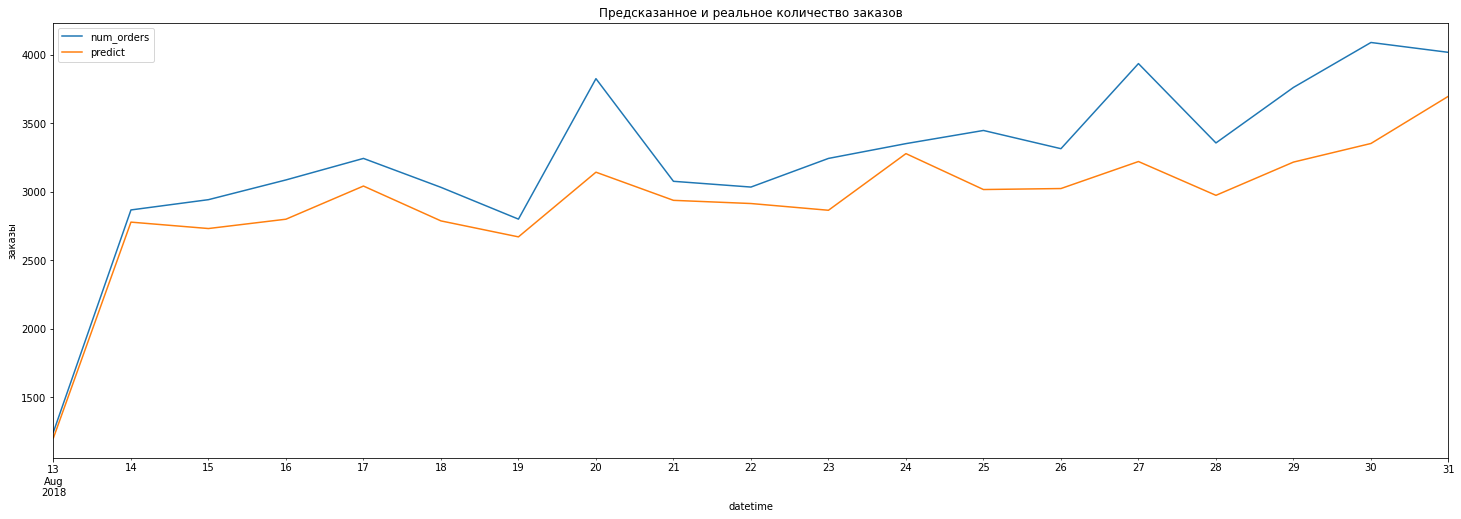

In [51]:
ax=y_test.resample('1D').sum().plot(ylabel='заказы')
pred=pd.Series(predict)
pred.index=y_test.index
pred.name='predict'
pd.concat([y_test,pred],1)['predict'].resample('1D').sum().plot(ax=ax)
plt.legend()
plt.title('Предсказанное и реальное количество заказов');

Сначала графики совпадают, но потом предсказания не успевают за реальным ростом количества заказов. 
    В последних датах происходит резкий рост: в данные для обучения, такой рост не вошёл.

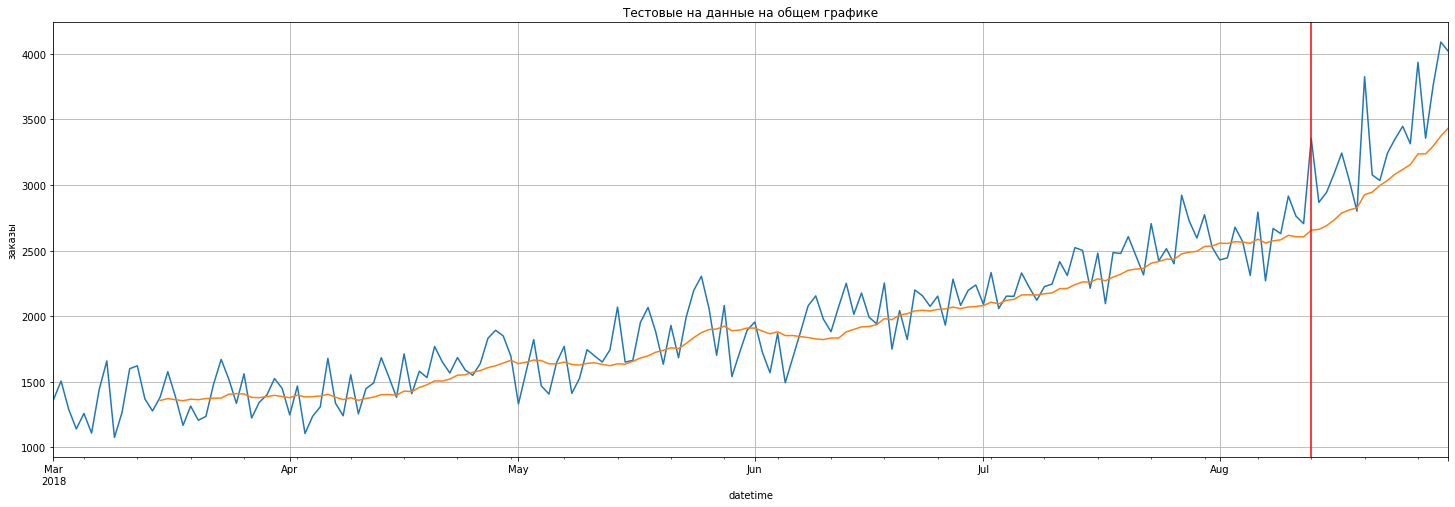

In [52]:
ax=df['num_orders'].resample('1D').sum().plot(figsize=(25,8),ylabel='заказы')
df['num_orders'].resample('1D').sum().rolling(15).mean().plot(grid=True)
plt.axvline(x='2018-08-13',color='red')
plt.title('Тестовые на данные на общем графике');

### Вывод

Лучший результат показала модель градиентного бустинга.

In [53]:
print('RMSE:', rmse.round(0))

RMSE: 42.0
